In [1]:
!pip install pydot graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from __future__ import print_function
#import keras
# Я поменяла импорт, т.к. keras устанавливается вместе с tensorflow как надстройка над ним и через такой импорт оптимизатор RMSprop становится доступен
# RMSprop как добавляет в градиентный спуск инерцию, так и меняет размер градиентного шага:  https://keras.io/api/optimizers/rmsprop/
from tensorflow import keras 

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D


import keras.backend as K


import pandas as pd

import os


In [4]:
num_classes = 10

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


# предобработка данных
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [5]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [21]:
# установка параметров нейросети
batch_size = 32
lr_ = 0.0001


epochs = 3
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [22]:
# инициализация RMSprop optimizer
opt = keras.optimizers.Adam(learning_rate=lr_, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [23]:
if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
Epoch 1/3
1563/1563 [==============================] - 259s 165ms/step - loss: 1.0160 - accuracy: 0.6427 - val_loss: 0.9211 - val_accuracy: 0.6790
Epoch 2/3
1563/1563 [==============================] - 257s 164ms/step - loss: 0.9641 - accuracy: 0.6607 - val_loss: 0.8905 - val_accuracy: 0.6940
Epoch 3/3
313/313 [==============================] - 12s 38ms/step - loss: 0.8605 - accuracy: 0.7023
Test loss: 0.860470712184906
Test accuracy: 0.7023000121116638


In [24]:
# # result_all = pd.DataFrame()
# result = pd.DataFrame([model.optimizer.get_config()])
# result['augmentation'] = str(data_augmentation)
# result['n_epochs'] = epochs
# result['Test accuracy'] = scores[1]
# result_all = result_all.append(result)
# result_all

,name,learning_rate,decay,beta_1,beta_2,epsilon,amsgrad,augmentation,n_epochs,Test accuracy,rho,momentum,centered
0,Adam,0.0001,0.000001,0.9,0.999,1.000000e-07,False,True,1,0.4630,NaN,NaN,NaN
0,RMSprop,0.0001,0.000001,NaN,NaN,1.000000e-07,NaN,True,1,0.4968,0.9,0.0,False
0,RMSprop,0.0001,0.000001,NaN,NaN,1.000000e-07,NaN,True,3,0.5844,0.9,0.0,False
0,Adam,0.0001,0.000001,0.9,0.999,1.000000e-07,False,True,3,0.6356,NaN,NaN,NaN
0,Adam,0.0001,0.000001,0.9,0.999,1.000000e-07,False,False,3,0.7023,NaN,NaN,NaN


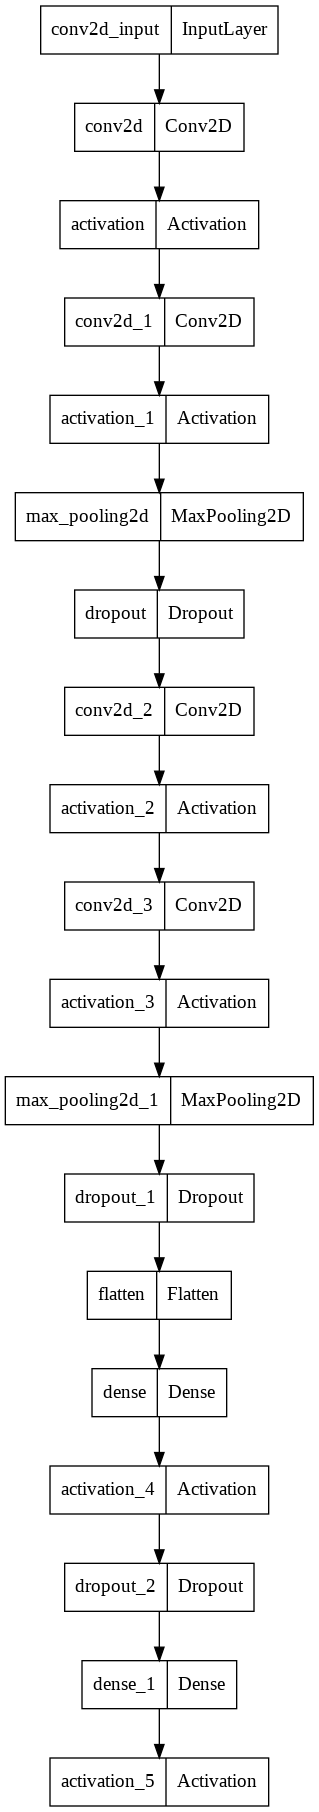

In [26]:
# визуализируем нашу простую модель
plot_model(model)

## Практическое задание

<ol>
    <li>Попробовать улучшить точность распознования образов cifar 10 сверточной нейронной сетью, рассмотренной на уроке. Приложить анализ с описанием того, что улучшает работу нейронной сети и что ухудшает.
    </li>
    <li>Описать также в анализе какие необоходимо внести изменения  в получившуюся у вас нейронную сеть если бы ей нужно было работать не с cifar10, а с MNIST, CIFAR100 и IMAGENET.
    </li>
</ol>

## Решение

1. Не стал использовать kerasTune, циклы или GridSearch, просто посчитал несколько комбинаций, результаты в табличке. Видим что без аугментации, оптимизатор Adam, увеличение числа эпох позволяет улучшить результат. 


2. Понятно что разные датасеты имеют разный размер и число классов, поэтому в архитектуру нейронной сети стоит прописать разное число выходов в финальном слое (CIFAR100 до 100, mnist до 10, IMAGENET до 1000). input_size считается автоматически, тут прблем нет. Кроме того есть проблема, что при очень маленьком размере рисунков, kernal_size может оказаться слишком большим при какой то свертке, это можно настроить автоматически, или внести изменения вручную. Кроме того у IMAGENET размеры  картинок разное, поэтому следует привести их к одному размеру - обрезать по центру слишком большие, или наоборот дополнить рамками (из нулей или единичек) самые мелкие.  Возможно какому то датасету прийдется добавить размерность 1.


